In [1]:
import sys
import os

notebook_path = os.getcwd() 
parent_dir = os.path.dirname(notebook_path)
project_root = os.path.dirname(parent_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
import state_NN_models
import Filters
import utils
import Systems
from utils import losses, trainer, utils
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateBayesianKalmanNet import StateBayesianKalmanNet
from state_NN_models.StateKalmanNet import StateKalmanNet
from state_NN_models.StateKalmanNetWithKnownR import StateKalmanNetWithKnownR

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [ ]:
state_dim_2d = 2
obs_dim_2d = 2

F_base_2d = torch.tensor([[1.0, 1.0], 
                          [0.0, 1.0]])

svd_F = torch.linalg.svd(F_base_2d)
F_true_2d = F_base_2d / svd_F.S[0]
print(F_true_2d)

H_true_2d = torch.eye(obs_dim_2d)

Q_true_2d = torch.eye(state_dim_2d) * 0.5 # Šum procesu
R_true_2d = torch.eye(obs_dim_2d) * 0.1 # Šum měření

# Počáteční podmínky
Ex0_true_2d = torch.tensor([[1.0], [0.0]])
P0_true_2d = torch.eye(state_dim_2d) * 1.5
F_model_2d = F_true_2d
H_model_2d = H_true_2d
Q_model_2d = torch.eye(state_dim_2d) * 0.1
R_model_2d = R_true_2d
Ex0_model_2d = torch.tensor([[0.5], [0.5]])
P0_model_2d = torch.eye(state_dim_2d) * 1.0

print("\nInicializuji 2D Linear_Canonical systém (replikace autorů)...")
sys_true = Systems.DynamicSystem(
    state_dim=state_dim_2d, obs_dim=obs_dim_2d,
    Ex0=Ex0_true_2d, P0=P0_true_2d,
    Q=Q_true_2d, R=R_true_2d,
    F=F_true_2d, H=H_true_2d,
    device=device
)
# sys_model = sys_true
# sys_model = Systems.DynamicSystem(
#     state_dim=state_dim_2d, obs_dim=obs_dim_2d,
#     Ex0=Ex0_model_2d, P0=P0_model_2d,
#     Q=Q_model_2d, R=R_model_2d,
#     F=F_model_2d, H=H_model_2d,
#     device=device
# )

sys_model=sys_true
print("... 2D systém inicializován.")

tensor([[0.6180, 0.6180],
        [0.0000, 0.6180]])

Inicializuji 2D Linear_Canonical systém (replikace autorů)...
... 2D systém inicializován.


In [6]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 20      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 100      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 500   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 200    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 8         # Dobrý kompromis

x_train, y_train = utils.generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy

model_config = {
    "hidden_size_multiplier": 10,
    "output_layer_multiplier": 4,
    "num_gru_layers": 1,
    "init_min_dropout": 0.5,
    "init_max_dropout": 0.8
}

train_config = {
    "total_train_iter": 1200,
    "learning_rate": 1e-4,
    "clip_grad": 10.0,
    "J_samples": 20,
    "validation_period": 20,
    "logging_period": 20,
    "warmup_iterations":0 # Trénuj prvních 400 iterací jen na MSE
}
# =================================================================================
# KROK 3: SPUŠTĚNÍ JEDNOHO TRÉNINKOVÉHO BĚHU NEBO NAČTENÍ HOTOVÉHO MODELU
# =================================================================================

print("="*80)
print("Připravuji Bayesian KalmanNet (BKN)...")
print(f"Parametry modelu: {model_config}")
print(f"Parametry tréninku: {train_config}")
print("="*80)

# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Definice cesty ke složce a souboru
save_dir = "LinearSystemWeights"
os.makedirs(save_dir, exist_ok=True)
weights_path = os.path.join(save_dir, "best_bkn_model_weights.pth")

# Vytvoření modelu (potřebujeme ho inicializovat v obou případech)
state_bkn_knet = StateBayesianKalmanNet(
    sys_model,
    device=device,
    weight_init=False,
    **model_config
).to(device)

# Podmínka pro načtení nebo trénink
if os.path.exists(weights_path):
    print(f"\nINFO: Uložené váhy nalezeny v '{weights_path}'.")
    print("Přeskakuji trénink a načítám hotový model...")
    
    # Načtení vah
    state_bkn_knet.load_state_dict(torch.load(weights_path, map_location=device))
    trained_model = state_bkn_knet
    
else:
    print("\nINFO: Váhy nebyly nalezeny. Spouštím plnohodnotný tréninkový běh...")
    
    # Spuštění tréninku
    results = trainer.training_session_trajectory_with_gaussian_nll_training_fcn(
        model=state_bkn_knet,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        **train_config
    )

    # `run_training_session` automaticky načte nejlepší model zpět,
    # takže `state_bkn_knet` nyní obsahuje váhy nejlepšího modelu.
    trained_model = results['final_model']
    
    # Uložení vah pro příští použití
    torch.save(trained_model.state_dict(), weights_path)
    print(f"\nINFO: Váhy modelu byly úspěšně uloženy do: {weights_path}")

    # Výpis metrik pouze pokud jsme trénovali
    print("\n" + "="*80)
    print("TRÉNINK DOKONČEN - FINÁLNÍ VÝSLEDKY Z NEJLEPŠÍHO MODELU")
    print("="*80)
    print(f"Nejlepší model byl nalezen v iteraci: {results['best_iter']}")
    print(f"Nejlepší dosažený validační ANEES: {results['best_val_anees']:.4f}")
    print("--- Metriky odpovídající tomuto nejlepšímu modelu ---")
    print(f"  MSE na validační sadě:       {results['best_val_mse']:.4f}")
    print(f"  NLL na validační sadě:       {results['best_val_nll']:.4f}")
    print("="*80)

# Prepnutí do evaluačního módu na konci bloku (klíčové pro BKN kvůli Dropoutu)
trained_model.eval()
print("\nModel BKN je plně připraven v proměnné 'trained_model'.")

Připravuji Bayesian KalmanNet (BKN)...
Parametry modelu: {'hidden_size_multiplier': 10, 'output_layer_multiplier': 4, 'num_gru_layers': 1, 'init_min_dropout': 0.5, 'init_max_dropout': 0.8}
Parametry tréninku: {'total_train_iter': 1200, 'learning_rate': 0.0001, 'clip_grad': 10.0, 'J_samples': 20, 'validation_period': 20, 'logging_period': 20, 'warmup_iterations': 100}
loaded with input normalization

INFO: Uložené váhy nalezeny v 'LinearSystemWeights/best_bkn_model_weights_real_aaaaaaaaaaaabbbba.pth'.
Přeskakuji trénink a načítám hotový model...

Model BKN je plně připraven v proměnné 'trained_model'.


In [8]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy
# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

save_dir = "LinearSystemWeights"
weights_path = os.path.join(save_dir, "best_knet_model_weights.pth")

# Vytvoření cílové složky (pokud ještě neexistuje, nic se nestane)
os.makedirs(save_dir, exist_ok=True)


state_knetR = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=12,returns_covariance=True).to(device)

if os.path.exists(weights_path):
    print(f"INFO: Uložené váhy nalezeny v '{weights_path}'.")
    print("Přeskakuji trénink a načítám hotový model...")
    
    # Načtení vah (map_location zajistí kompatibilitu, pokud bys např. trénoval na GPU a načítal na CPU)
    state_knetR.load_state_dict(torch.load(weights_path, map_location=device))
    
else:
    print("INFO: Váhy nebyly nalezeny. Spouštím trénink modelu...")
    
    # Spuštění tréninku
    trainer.train_state_KalmanNet(
        model=state_knetR, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        device=device, 
        epochs=100, 
        lr=1e-4,
        early_stopping_patience=30
    )
    
    # Po úspěšném tréninku váhy rovnou uložíme pro příští spuštění
    torch.save(state_knetR.state_dict(), weights_path)
    print(f"Trénink dokončen. Váhy byly bezpečně uloženy do '{weights_path}'.")

# Prepnutí do evaluačního módu (dobrá praxe před testováním)
state_knetR.eval()

DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
INFO: Uložené váhy nalezeny v 'LinearSystemWeights/best_knet_model_weights.pth'.
Přeskakuji trénink a načítám hotový model...


StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Sequential(
      (0): Linear(in_features=8, out_features=384, bias=True)
      (1): ReLU()
    )
    (gru): GRU(384, 8)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): ReLU()
    )
    (output_final_linear): Sequential(
      (0): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import Filters

# ==============================================================================
# 0. PŘEDPOKLADY - ZDE PŘIŘAĎTE VAŠE NATRÉNOVANÉ MODELY
# ==============================================================================
try:
    trained_model_bkn = trained_model
    trained_model_knetR = state_knetR
    print("INFO: Všechny natrénované modely nalezeny a přiřazeny.")
except NameError:
    print("VAROVÁNÍ: Některé z proměnných `trained_model`, nebo `state_knetR` nebyly nalezeny.")
    print("         Ujistěte se, že jste nejprve úspěšně dokončili trénink všech modelů.")

# ==============================================================================
# 1. KONFIGURACE TESTU
# ==============================================================================
TEST_SEQ_LEN = 1000
NUM_TEST_TRAJ = 10
J_SAMPLES_TEST = 25

# ==============================================================================
# 2. PŘÍPRAVA DAT
# ==============================================================================
print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Generování dat dokončeno.")

# ==============================================================================
# 3. INICIALIZACE FILTRŮ PRO POROVNÁNÍ (POUZE IDEÁLNÍ MODEL)
# ==============================================================================
ekf_ideal = Filters.ExtendedKalmanFilter(sys_true)
ukf_ideal = Filters.UnscentedKalmanFilter(sys_true)
kf_ideal = Filters.KalmanFilter(sys_true)
# Oprava: předáváme sys_true místo sys_model pro ideální test
akf_mdm_ideal = Filters.AdaptiveKalmanFilter_default(sys_true, mdm_L=3, mdm_version=2, lambda_rls=1.0, init_sigma_rls_value=0.1) 
akf_mehra_ideal = Filters.AdaptiveKalmanFilter_mehra_offline(sys_true, num_iterations=5)

print("Všechny model-based filtry (EKF, UKF, KF, AKF, AKF-Mehra) s ideálním modelem inicializovány.")

# ==============================================================================
# 4. VYHODNOCOVACÍ SMYČKA
# ==============================================================================
# Seznamy pro ukládání výsledků z každé trajektorie
all_x_true_cpu = []
all_x_hat_bkn_cpu, all_P_hat_bkn_cpu = [], []
all_x_hat_knetR_cpu, all_P_hat_knetR_cpu = [], []
all_x_hat_ekf_ideal_cpu, all_P_hat_ekf_ideal_cpu = [], []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_kf_ideal_cpu, all_P_hat_kf_ideal_cpu = [], []
all_x_hat_akf_mdm_ideal_cpu, all_P_hat_akf_mdm_ideal_cpu = [], []
all_x_hat_akf_mehra_ideal_cpu = []  # Odebráno P pro Mehru

print(f"\nVyhodnocuji modely na {NUM_TEST_TRAJ} testovacích trajektoriích...")

trained_model_bkn.eval() 
trained_model_knetR.eval()

with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)
        
        # --- A. Bayesian KalmanNet (Trajectory-wise) ---
        ensemble_trajectories = []
        for j in range(J_SAMPLES_TEST):
            trained_model_bkn.reset(batch_size=1, initial_state=initial_state)
            current_x_hats = []
            for t in range(1, TEST_SEQ_LEN):
                x_filtered_t, _ = trained_model_bkn.step(y_test_seq_gpu[t, :].unsqueeze(0))
                current_x_hats.append(x_filtered_t)
            ensemble_trajectories.append(torch.cat(current_x_hats, dim=0))
        ensemble = torch.stack(ensemble_trajectories, dim=0)
        predictions_bkn = ensemble.mean(dim=0)
        diff = ensemble - predictions_bkn.unsqueeze(0)
        covariances_bkn = (diff.unsqueeze(-1) @ diff.unsqueeze(-2)).mean(dim=0)
        full_x_hat_bkn = torch.cat([initial_state, predictions_bkn], dim=0)
        full_P_hat_bkn = torch.cat([sys_true.P0.unsqueeze(0), covariances_bkn], dim=0)

        print(f"Trajektorie {i + 1}/{NUM_TEST_TRAJ}: Bayesian KNet (BKN) dokončen.")
        # --- C. StateKalmanNetWithKnownR ---
        trained_model_knetR.reset(batch_size=1, initial_state=initial_state)
        knetR_preds_x, knetR_preds_P = [], []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t, P_filtered_t = trained_model_knetR.step(y_test_seq_gpu[t, :].unsqueeze(0))
            knetR_preds_x.append(x_filtered_t)
            knetR_preds_P.append(P_filtered_t)
        full_x_hat_knetR = torch.cat([initial_state, torch.cat(knetR_preds_x, dim=0)], dim=0)
        
        processed_P_list = []
        for p_tensor in knetR_preds_P:
            while p_tensor.dim() < 2:
                p_tensor = p_tensor.unsqueeze(-1)
            if p_tensor.dim() > 2 and p_tensor.shape[0] == 1:
                p_tensor = p_tensor.squeeze(0)
            processed_P_list.append(p_tensor)

        P_sequence_knetR = torch.stack(processed_P_list, dim=0)
        P0_for_cat = sys_true.P0.clone()
        while P0_for_cat.dim() < P_sequence_knetR.dim():
            P0_for_cat = P0_for_cat.unsqueeze(0)
            
        full_P_hat_knetR = torch.cat([P0_for_cat, P_sequence_knetR], dim=0)

        print(f"Trajektorie {i + 1}/{NUM_TEST_TRAJ}: StateKalmanNetWithKnownR (KNetR) dokončen.")
        # --- Klasické a adaptivní filtry ---
        ekf_i_res = ekf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
        full_x_hat_ekf_i = ekf_i_res['x_filtered']
        full_P_hat_ekf_i = ekf_i_res['P_filtered']
        print(f"Trajektorie {i + 1}/{NUM_TEST_TRAJ}: EKF (Ideální model) dokončen.")

        ukf_i_res = ukf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        print(f"Trajektorie {i + 1}/{NUM_TEST_TRAJ}: UKF (Ideální model) dokončen.")
        kf_i_res = kf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
        full_x_hat_kf_i = kf_i_res['x_filtered']
        full_P_hat_kf_i = kf_i_res['P_filtered']
        print(f"Trajektorie {i + 1}/{NUM_TEST_TRAJ}: KF (Ideální model) dokončen.")
        afk_mdm_i_res,_,_ = akf_mdm_ideal.process_sequence_adaptively(y_test_seq_gpu)
        full_x_hat_akf_mdm_i = afk_mdm_i_res['x_filtered']
        full_P_hat_akf_mdm_i = afk_mdm_i_res['P_filtered'] 
        print(f"Trajektorie {i + 1}/{NUM_TEST_TRAJ}: AKF-MDM (Ideální model) dokončen.")

        akf_mehra_i_res = akf_mehra_ideal.process_sequence(y_test_seq_gpu)
        full_x_hat_akf_mehra_i = akf_mehra_i_res['x_filtered']   
        print(f"Trajektorie {i + 1}/{NUM_TEST_TRAJ}: AKF-Mehra (Ideální model) dokončen.")
        # Záměrně vynecháno stahování P_filtered pro Mehru
        
        # Ukládání na CPU
        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        all_x_hat_bkn_cpu.append(full_x_hat_bkn.cpu()); all_P_hat_bkn_cpu.append(full_P_hat_bkn.cpu())
        all_x_hat_knetR_cpu.append(full_x_hat_knetR.cpu()); all_P_hat_knetR_cpu.append(full_P_hat_knetR.cpu())
        all_x_hat_ekf_ideal_cpu.append(full_x_hat_ekf_i.cpu()); all_P_hat_ekf_ideal_cpu.append(full_P_hat_ekf_i.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_kf_ideal_cpu.append(full_x_hat_kf_i.cpu()); all_P_hat_kf_ideal_cpu.append(full_P_hat_kf_i.cpu())
        all_x_hat_akf_mdm_ideal_cpu.append(full_x_hat_akf_mdm_i.cpu()); all_P_hat_akf_mdm_ideal_cpu.append(full_P_hat_akf_mdm_i.cpu())
        all_x_hat_akf_mehra_ideal_cpu.append(full_x_hat_akf_mehra_i.cpu())

        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

# ==============================================================================
# 5. FINÁLNÍ VÝPOČET A VÝPIS METRIK
# ==============================================================================
# Seznamy pro sběr metrik
mse_bkn, anees_bkn = [], []; mse_knetR, anees_knetR = [], []
mse_ekf_ideal, anees_ekf_ideal = [], []
mse_ukf_ideal, anees_ukf_ideal = [], []
mse_kf_ideal, anees_kf_ideal = [], []
mse_akf_mdm_ideal, anees_akf_mdm_ideal = [], []
mse_akf_mehra_ideal = [] 

print("\nPočítám finální metriky pro jednotlivé trajektorie...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        
        def get_metrics(x_hat, P_hat):
            mse = F.mse_loss(x_hat[1:], x_true[1:]).item()
            anees = utils.calculate_anees_vectorized(x_true.unsqueeze(0), x_hat.unsqueeze(0), P_hat.unsqueeze(0))
            return mse, anees

        # Výpočty pro všechny modely (s kovariancí)
        mse, anees = get_metrics(all_x_hat_bkn_cpu[i], all_P_hat_bkn_cpu[i]); mse_bkn.append(mse); anees_bkn.append(anees)
        mse, anees = get_metrics(all_x_hat_knetR_cpu[i], all_P_hat_knetR_cpu[i]); mse_knetR.append(mse); anees_knetR.append(anees)
        mse, anees = get_metrics(all_x_hat_ekf_ideal_cpu[i], all_P_hat_ekf_ideal_cpu[i]); mse_ekf_ideal.append(mse); anees_ekf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_kf_ideal_cpu[i], all_P_hat_kf_ideal_cpu[i]); mse_kf_ideal.append(mse); anees_kf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_akf_mdm_ideal_cpu[i], all_P_hat_akf_mdm_ideal_cpu[i]); mse_akf_mdm_ideal.append(mse); anees_akf_mdm_ideal.append(anees)
        
        # Výpočet pouze MSE pro Mehru
        mse_mehra = F.mse_loss(all_x_hat_akf_mehra_ideal_cpu[i][1:], x_true[1:]).item()
        mse_akf_mehra_ideal.append(mse_mehra)

# Funkce pro bezpečné průměrování
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

# --- Finální výpis tabulky ---
print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů - PŘESNÁ ZNALOST MODELU)")
print("="*80)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
print(f"{'--- Data-Driven Models ---':<35} | {'(nižší je lepší)':<20} | {'(bližší ' + str(float(state_dim_for_nees)) + ' je lepší)':<20}")
print(f"{'Bayesian KNet (BKN)':<35} | {avg(mse_bkn):<20.4f} | {avg(anees_bkn):<20.4f}")
print(f"{'KNet with Known R (KNetR)':<35} | {avg(mse_knetR):<20.4f} | {avg(anees_knetR):<20.4f}")
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
print(f"{'EKF (Ideální model)':<35} | {avg(mse_ekf_ideal):<20.4f} | {avg(anees_ekf_ideal):<20.4f}")
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
print(f"{'AKF-MDM (Ideální model)':<35} | {avg(mse_akf_mdm_ideal):<20.4f} | {avg(anees_akf_mdm_ideal):<20.4f}")
print(f"{'AKF-Mehra (Ideální model)':<35} | {avg(mse_akf_mehra_ideal):<20.4f} | {'N/A':<20}")
print(f"{'KF (Ideální model - OPTIMUM)':<35} | {avg(mse_kf_ideal):<20.4f} | {avg(anees_kf_ideal):<20.4f}")
print("="*80)

INFO: Všechny natrénované modely nalezeny a přiřazeny.

Generuji 10 testovacích trajektorií o délce 1000...
Generování dat dokončeno.
Všechny model-based filtry (EKF, UKF, KF, AKF, AKF-Mehra) s ideálním modelem inicializovány.

Vyhodnocuji modely na 10 testovacích trajektoriích...
Trajektorie 1/10: Bayesian KNet (BKN) dokončen.
Trajektorie 1/10: StateKalmanNetWithKnownR (KNetR) dokončen.
Trajektorie 1/10: EKF (Ideální model) dokončen.
Trajektorie 1/10: UKF (Ideální model) dokončen.


Trajektorie 1/10: KF (Ideální model) dokončen.


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 959.17it/s]


Trajektorie 1/10: AKF-MDM (Ideální model) dokončen.

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Trajektorie 1/10: AKF-Mehra (Ideální model) dokončen.
Dokončena trajektorie 1/10...
Trajektorie 2/10: Bayesian KNet (BKN) dokončen.
Trajektorie 2/10: StateKalmanNetWithKnownR (KNetR) dokončen.
Trajektorie 2/10: EKF (Ideální model) dokončen.
Trajektorie 2/10: UKF (Ideální model) dokončen.


Trajektorie 2/10: KF (Ideální model) dokončen.


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 967.76it/s]


Trajektorie 2/10: AKF-MDM (Ideální model) dokončen.

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Trajektorie 2/10: AKF-Mehra (Ideální model) dokončen.
Dokončena trajektorie 2/10...
Trajektorie 3/10: Bayesian KNet (BKN) dokončen.
Trajektorie 3/10: StateKalmanNetWithKnownR (KNetR) dokončen.
Trajektorie 3/10: EKF (Ideální model) dokončen.
Trajektorie 3/10: UKF (Ideální model) dokončen.


Trajektorie 3/10: KF (Ideální model) dokončen.


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 821.17it/s]


Trajektorie 3/10: AKF-MDM (Ideální model) dokončen.

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Trajektorie 3/10: AKF-Mehra (Ideální model) dokončen.
Dokončena trajektorie 3/10...
Trajektorie 4/10: Bayesian KNet (BKN) dokončen.
Trajektorie 4/10: StateKalmanNetWithKnownR (KNetR) dokončen.
Trajektorie 4/10: EKF (Ideální model) dokončen.
Trajektorie 4/10: UKF (Ideální model) dokončen.


Trajektorie 4/10: KF (Ideální model) dokončen.


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 933.13it/s]


Trajektorie 4/10: AKF-MDM (Ideální model) dokončen.

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Trajektorie 4/10: AKF-Mehra (Ideální model) dokončen.
Dokončena trajektorie 4/10...
Trajektorie 5/10: Bayesian KNet (BKN) dokončen.
Trajektorie 5/10: StateKalmanNetWithKnownR (KNetR) dokončen.
Trajektorie 5/10: EKF (Ideální model) dokončen.
Trajektorie 5/10: UKF (Ideální model) dokončen.


Trajektorie 5/10: KF (Ideální model) dokončen.


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 939.43it/s]


Trajektorie 5/10: AKF-MDM (Ideální model) dokončen.

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Trajektorie 5/10: AKF-Mehra (Ideální model) dokončen.
Dokončena trajektorie 5/10...
Trajektorie 6/10: Bayesian KNet (BKN) dokončen.
Trajektorie 6/10: StateKalmanNetWithKnownR (KNetR) dokončen.
Trajektorie 6/10: EKF (Ideální model) dokončen.
Trajektorie 6/10: UKF (Ideální model) dokončen.


Trajektorie 6/10: KF (Ideální model) dokončen.


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 836.79it/s]


Trajektorie 6/10: AKF-MDM (Ideální model) dokončen.

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Trajektorie 6/10: AKF-Mehra (Ideální model) dokončen.
Dokončena trajektorie 6/10...
Trajektorie 7/10: Bayesian KNet (BKN) dokončen.
Trajektorie 7/10: StateKalmanNetWithKnownR (KNetR) dokončen.
Trajektorie 7/10: EKF (Ideální model) dokončen.
Trajektorie 7/10: UKF (Ideální model) dokončen.


Trajektorie 7/10: KF (Ideální model) dokončen.


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 910.09it/s]


Trajektorie 7/10: AKF-MDM (Ideální model) dokončen.

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Trajektorie 7/10: AKF-Mehra (Ideální model) dokončen.
Dokončena trajektorie 7/10...
Trajektorie 8/10: Bayesian KNet (BKN) dokončen.
Trajektorie 8/10: StateKalmanNetWithKnownR (KNetR) dokončen.
Trajektorie 8/10: EKF (Ideální model) dokončen.
Trajektorie 8/10: UKF (Ideální model) dokončen.


Trajektorie 8/10: KF (Ideální model) dokončen.


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 905.83it/s]


Trajektorie 8/10: AKF-MDM (Ideální model) dokončen.

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Trajektorie 8/10: AKF-Mehra (Ideální model) dokončen.
Dokončena trajektorie 8/10...
Trajektorie 9/10: Bayesian KNet (BKN) dokončen.
Trajektorie 9/10: StateKalmanNetWithKnownR (KNetR) dokončen.
Trajektorie 9/10: EKF (Ideální model) dokončen.
Trajektorie 9/10: UKF (Ideální model) dokončen.


Trajektorie 9/10: KF (Ideální model) dokončen.


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 827.33it/s]


Trajektorie 9/10: AKF-MDM (Ideální model) dokončen.

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Trajektorie 9/10: AKF-Mehra (Ideální model) dokončen.
Dokončena trajektorie 9/10...
Trajektorie 10/10: Bayesian KNet (BKN) dokončen.
Trajektorie 10/10: StateKalmanNetWithKnownR (KNetR) dokončen.
Trajektorie 10/10: EKF (Ideální model) dokončen.
Trajektorie 10/10: UKF (Ideální model) dokončen.


Trajektorie 10/10: KF (Ideální model) dokončen.


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 855.65it/s]


Trajektorie 10/10: AKF-MDM (Ideální model) dokončen.

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Trajektorie 10/10: AKF-Mehra (Ideální model) dokončen.
Dokončena trajektorie 10/10...

Počítám finální metriky pro jednotlivé trajektorie...

FINÁLNÍ VÝSLEDKY (průměr přes 10 běhů - PŘESNÁ ZNALOST MODELU)
Model                               | Průměrné MSE         | Průměrný ANEES      
--------------------------------------------------------------------------------
--- Data-Driven Models ---          | (nižší je lepší)     | (bližší 2.0 je lepší)
Bayesian KNet (BKN)                 | 0.1054               | 2.5941              
KNet with Known R (KNetR)           | 0.0839               | 1.9703              
--------------------------------------------------------------------------------
--- Model-Based Filters ---         |                      |                     
EKF (Ideální model)                 | 0.0838               | 1.9834              
UKF (Ideální model)                 | 0.0838               | 1.9834              
AKF-MDM (Ideální model)             | 0.0885              

# Kalman Gain comparison

Předpočítávám výsledky filtrů a extrahuji Kalmanovy zisky pro vykreslení...


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 915.55it/s]



--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 735.86it/s]



--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Processing sequence adaptively: 100%|██████████| 1000/1000 [00:01<00:00, 943.63it/s]



--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000



Generuji grafy konvergence Frobeniovy normy...


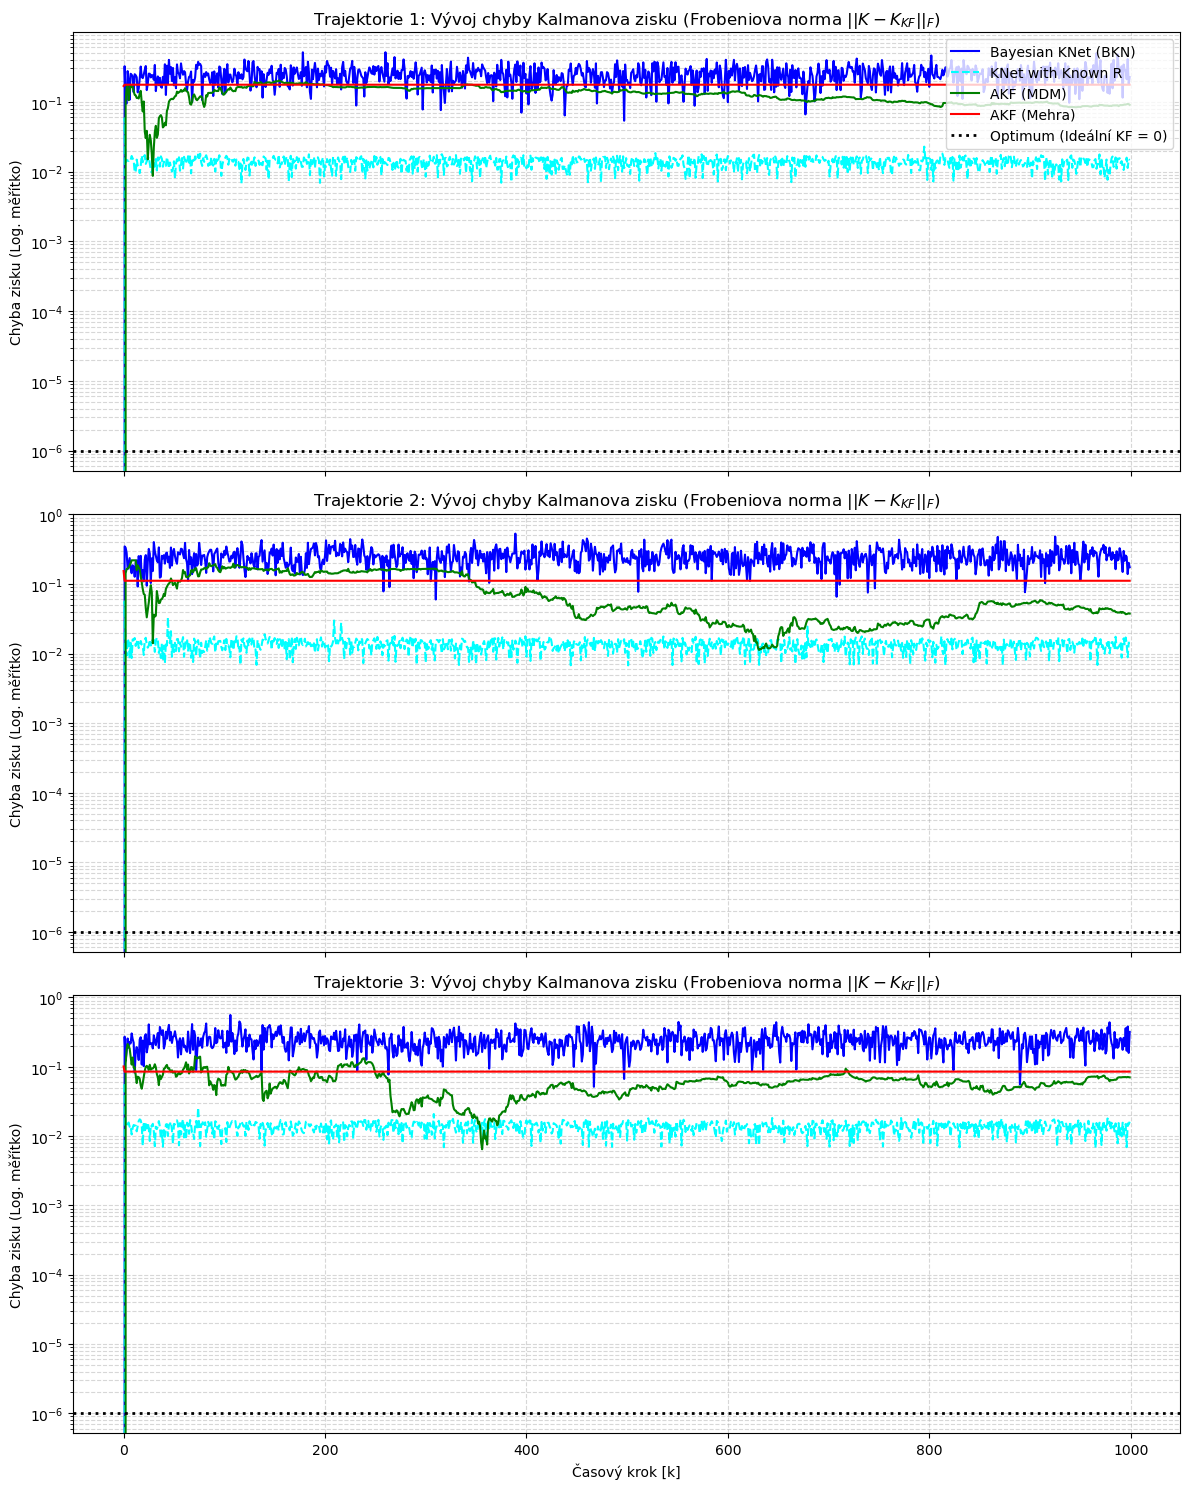


NUMERICKÉ POROVNÁNÍ KALMANOVA ZISKU V USTÁLENÉM STAVU (Steady-State)
Hodnoceno jako průměrná Frobeniova norma z posledních 20 % kroků.
CÍL: Číslo co nejblíže k nule (shoda s ideálním Riccatiho řešením)
Filtr                          | Průměrná SS Chyba (norma)
--------------------------------------------------------------------------------
Bayesian KNet (BKN)            | 0.246153                 
KNet with Known R              | 0.013415                 
AKF (MDM)                      | 0.064258                 
AKF (Mehra)                    | 0.123936                 


In [10]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# ==============================================================================
# ANALÝZA VÝVOJE KALMANOVA ZISKU A POROVNÁNÍ VŮČI OPTIMU (FROBENIOVA NORMA)
# ==============================================================================
num_plot_traj = min(3, NUM_TEST_TRAJ)

print("Předpočítávám výsledky filtrů a extrahuji Kalmanovy zisky pro vykreslení...")

# Seznamy pro uložení historie chyb (Frobeniova norma)
frob_errors_bkn = []
frob_errors_knetR = []
frob_errors_mdm = []
frob_errors_mehra = []

trained_model_bkn.eval()
trained_model_knetR.eval()

with torch.no_grad():
    # Procházíme testovací trajektorie
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        if i >= num_plot_traj:
            break
            
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)
        seq_len = y_test_seq_gpu.shape[0]

        # --- 1. Ideální KF (Benchmark - Absolutní Optimum) ---
        res_ideal = kf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
        K_kf = res_ideal['Kalman_gain'].cpu()  # Očekávaný tvar: [seq_len, state_dim, obs_dim]
        
        # --- 2. AKF MDM (Ideální model) ---
        res_mdm,_,_ = akf_mdm_ideal.process_sequence_adaptively(y_test_seq_gpu)
        K_mdm = res_mdm['Kalman_gain'].cpu()
        
        # --- 3. AKF Mehra (Ideální model) ---
        res_mehra = akf_mehra_ideal.process_sequence(y_test_seq_gpu)
        K_mehra = res_mehra['Kalman_gain'].cpu()
        
        # Ošetření: Pokud Mehra vrací konstantní zisk pro celou trajektorii, expandujeme ho
        if K_mehra.dim() == 2:
            K_mehra = K_mehra.unsqueeze(0).expand(seq_len, -1, -1)
        elif K_mehra.shape[0] < seq_len:
            pad_len = seq_len - K_mehra.shape[0]
            K_mehra = torch.cat([K_kf[:pad_len], K_mehra], dim=0)

        # --- 4. Bayesian KalmanNet (Zprůměrovaný zisk přes J vzorků) ---
        K_bkn_ensemble = []
        for j in range(J_SAMPLES_TEST):
            trained_model_bkn.reset(batch_size=1, initial_state=initial_state)
            for t in range(1, seq_len):
                trained_model_bkn.step(y_test_seq_gpu[t, :].unsqueeze(0))
            
            # Získáme [seq_len-1, 1, state_dim, obs_dim], odstraníme batch (squeeze)
            K_history = trained_model_bkn.get_kalman_gain_history().squeeze(1).cpu()
            # Doplníme nultý krok (např. z KF), aby seděla délka na seq_len
            K_history_full = torch.cat([K_kf[0].unsqueeze(0), K_history], dim=0)
            K_bkn_ensemble.append(K_history_full)
        
        # Zprůměrování zisku přes ensemble
        K_bkn = torch.stack(K_bkn_ensemble, dim=0).mean(dim=0)

        # --- 5. KalmanNet s Known R (KNetR) ---
        trained_model_knetR.reset(batch_size=1, initial_state=initial_state)
        for t in range(1, seq_len):
            trained_model_knetR.step(y_test_seq_gpu[t, :].unsqueeze(0))
            
        K_history_knetR = trained_model_knetR.get_kalman_gain_history().squeeze(1).cpu()
        K_knetR = torch.cat([K_kf[0].unsqueeze(0), K_history_knetR], dim=0)

        # --- VÝPOČET FROBENIOVY NORMY CHYBY ||K_model - K_KF||_F ---
        # dim=(1,2) spočítá normu pro každou matici v každém časovém kroku
        err_bkn = torch.linalg.matrix_norm(K_bkn - K_kf, ord='fro', dim=(1,2))
        err_knetR = torch.linalg.matrix_norm(K_knetR - K_kf, ord='fro', dim=(1,2))
        err_mdm = torch.linalg.matrix_norm(K_mdm - K_kf, ord='fro', dim=(1,2))
        err_mehra = torch.linalg.matrix_norm(K_mehra - K_kf, ord='fro', dim=(1,2))
        
        frob_errors_bkn.append(err_bkn)
        frob_errors_knetR.append(err_knetR)
        frob_errors_mdm.append(err_mdm)
        frob_errors_mehra.append(err_mehra)

# ==============================================================================
# GRAFICKÁ A NUMERICKÁ PREZENTACE VÝSLEDKŮ
# ==============================================================================
print("\nGeneruji grafy konvergence Frobeniovy normy...")

fig, axes = plt.subplots(num_plot_traj, 1, figsize=(12, 5 * num_plot_traj), sharex=True)
if num_plot_traj == 1: axes = [axes]

# Pro numerickou tabulku vezmeme průměrnou chybu za posledních např. 20 % trajektorie,
# abychom hodnotili "ustálený stav" (steady-state).
steady_state_ratio = 0.2
idx_steady = int((1 - steady_state_ratio) * TEST_SEQ_LEN)

num_bkn_ss, num_knetR_ss, num_mdm_ss, num_mehra_ss = [], [], [], []

for i in range(num_plot_traj):
    ax = axes[i]
    
    # Vykreslení chyb pro jednotlivé filtry
    ax.plot(frob_errors_bkn[i].numpy(), label='Bayesian KNet (BKN)', color='blue', linewidth=1.5)
    ax.plot(frob_errors_knetR[i].numpy(), label='KNet with Known R', color='cyan', linestyle='--', linewidth=1.5)
    ax.plot(frob_errors_mdm[i].numpy(), label='AKF (MDM)', color='green', linewidth=1.5)
    ax.plot(frob_errors_mehra[i].numpy(), label='AKF (Mehra)', color='red', linewidth=1.5)
    
    # Benchmarková ideální čára (Chyba = 0)
    # Log scale nejde do absolutní nuly, tak dáme čáru těsně k nule
    ax.axhline(1e-6, color='black', linestyle=':', linewidth=2, label='Optimum (Ideální KF = 0)')
    
    ax.set_title(f"Trajektorie {i+1}: Vývoj chyby Kalmanova zisku (Frobeniova norma $||K - K_{{KF}}||_F$)")
    ax.set_ylabel("Chyba zisku (Log. měřítko)")
    ax.set_yscale('log') # Extrémně důležité pro zobrazení konvergence
    ax.grid(True, which="both", ls="--", alpha=0.5)
    
    if i == 0:
        ax.legend(loc='upper right')
        
    # Výpočet numerických hodnot pro ustálený stav
    num_bkn_ss.append(frob_errors_bkn[i][idx_steady:].mean().item())
    num_knetR_ss.append(frob_errors_knetR[i][idx_steady:].mean().item())
    num_mdm_ss.append(frob_errors_mdm[i][idx_steady:].mean().item())
    num_mehra_ss.append(frob_errors_mehra[i][idx_steady:].mean().item())

axes[-1].set_xlabel("Časový krok [k]")
plt.tight_layout()
plt.show()

# --- Výpis numerických výsledků ---
print("\n" + "="*80)
print("NUMERICKÉ POROVNÁNÍ KALMANOVA ZISKU V USTÁLENÉM STAVU (Steady-State)")
print(f"Hodnoceno jako průměrná Frobeniova norma z posledních {steady_state_ratio*100:.0f} % kroků.")
print("CÍL: Číslo co nejblíže k nule (shoda s ideálním Riccatiho řešením)")
print("="*80)
print(f"{'Filtr':<30} | {'Průměrná SS Chyba (norma)':<25}")
print("-" * 80)
print(f"{'Bayesian KNet (BKN)':<30} | {np.mean(num_bkn_ss):<25.6f}")
print(f"{'KNet with Known R':<30} | {np.mean(num_knetR_ss):<25.6f}")
print(f"{'AKF (MDM)':<30} | {np.mean(num_mdm_ss):<25.6f}")
print(f"{'AKF (Mehra)':<30} | {np.mean(num_mehra_ss):<25.6f}")
print("="*80)